In [1]:
import pandas as pd
import numpy as np
import itertools

from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, MaxPool2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

np.random.seed()
sns.set(style='white', context='notebook', palette='deep')

print("Done")

Done


In [16]:
# importing custom libraries
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from graphic_utils.symbols import draw_symbols
from graphic_utils.confusion_matrix import plot_confusion_matrix

# adding support of zip files
from zipfile import ZipFile

In [18]:
# Load the training data
dataset = pd.read_csv("../data/train.csv.zip", compression='zip')

#Load the test data for the competition submission
competition_dataset = pd.read_csv("../data/test.csv.zip", compression='zip')

dataset.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


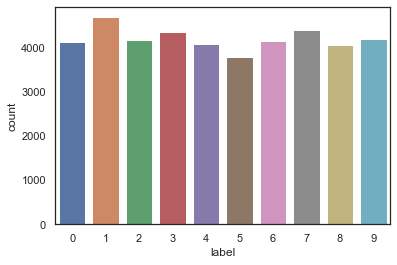

In [19]:
# A label is the thing we're predicting
label = dataset["label"]

# A feature is an input variable, in this case a 28 by 28 pixels image
# Drop 'label' column
feature = dataset.drop(labels = ["label"], axis = 1)

# let's check we have a good distribution of the handwritten digits
g = sns.countplot(x=label)

In [20]:
# free some space
del dataset 

print("Cleaned up")

Cleaned up


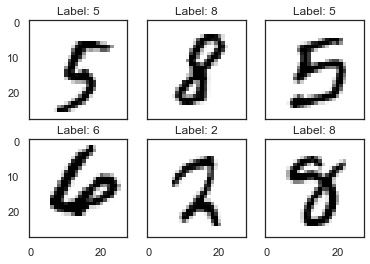

In [21]:
draw_symbols(feature, label)


In [22]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
label = to_categorical(label, num_classes = 10)

# Normalize between 0 and 1 the data (The pixel-value is an integer between 0 and 255)
feature = feature / 255.0
competition_dataset = competition_dataset / 255.0

print("Done")

Done


In [23]:
# Split the dataset into train and validation set
# Keep 10% for the validation and 90% for the training
# Stratify is argument to keep trainingset evenly balanced ofver the labels (eg validation set not only the digit 5)

feature_train, feature_val, label_train, label_val = train_test_split(feature, label, test_size = 0.1, stratify=label)

In [24]:
# First model is a dense neural network model with 5 layers
model_1 = Sequential()
model_1.add(Dense(200, activation = "relu", input_shape = (784,)))
model_1.add(Dense(100, activation = "relu"))
model_1.add(Dense(60, activation = "relu"))
model_1.add(Dense(30, activation = "relu"))
model_1.add(Dense(10, activation = "softmax"))

# Define the optimizer and compile the model
optimizer = optimizers.SGD(lr=0.03, clipnorm=5.)
model_1.compile(optimizer= optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

print (model_1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_7 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_8 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                310       
Total params: 185,300
Trainable params: 185,300
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
# With this model you should be able to achieve around 95.5% accuracy

history = model_1.fit(feature_train, label_train, batch_size = 100, epochs = 8, 
          validation_data = (feature_val, label_val), verbose = 1)

Epoch 1/8
378/378 [==============================] - 2s 3ms/step - loss: 1.5971 - accuracy: 0.4689 - val_loss: 0.3754 - val_accuracy: 0.8917
Epoch 2/8
378/378 [==============================] - 1s 2ms/step - loss: 0.3423 - accuracy: 0.8993 - val_loss: 0.2683 - val_accuracy: 0.9167
Epoch 3/8
378/378 [==============================] - 1s 2ms/step - loss: 0.2454 - accuracy: 0.9264 - val_loss: 0.2087 - val_accuracy: 0.9352
Epoch 4/8
378/378 [==============================] - 1s 2ms/step - loss: 0.1901 - accuracy: 0.9456 - val_loss: 0.2163 - val_accuracy: 0.9333
Epoch 5/8
378/378 [==============================] - 1s 2ms/step - loss: 0.1600 - accuracy: 0.9528 - val_loss: 0.1689 - val_accuracy: 0.9452
Epoch 6/8
378/378 [==============================] - 1s 2ms/step - loss: 0.1358 - accuracy: 0.9609 - val_loss: 0.1446 - val_accuracy: 0.9552
Epoch 7/8
378/378 [==============================] - 1s 2ms/step - loss: 0.1249 - accuracy: 0.9642 - val_loss: 0.1296 - val_accuracy: 0.9583
Epoch 8/8
378

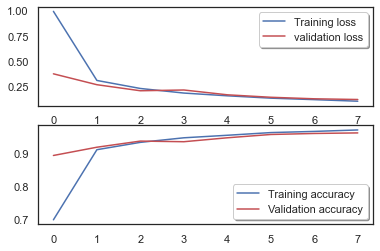

In [26]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

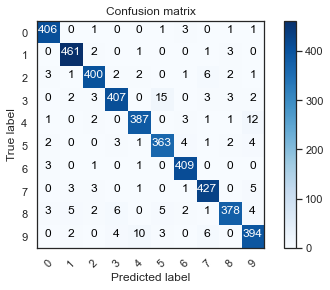

In [27]:
# Predict the values from the validation dataset
Y_pred = model_1.predict(feature_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(label_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [28]:
# predict results
results = model_1.predict(competition_dataset)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [29]:
print(results)

0        2
1        0
2        9
3        9
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64
